## A complex (composite/multistep) reaction `A <-> C` derived from 2 coupled elementary reactions: 
## `A <-> B` and `B <-> C`  
We are given the time evolution of the complex reaction,  
and want to determine whether it can be modeled as an elementary reaction.  

In PART 1, a time evolution of [A], [B] and [C] is obtained by simulation  
In PART 2, the time functions generated in Part 1 are taken as a _starting point,_ to explore how to model the composite reaction `A <-> C`  

**Background**: please see experiments `cascade_1` and `mystery_reaction_1`

In [1]:
LAST_REVISED = "July 26, 2024"
LIFE123_VERSION = "1.0.0.beta.38"    # Version this experiment is based on

In [2]:
#import set_path            # Using MyBinder?  Uncomment this before running the next cell!
                            # Importing this module will add the project's home directory to sys.path

In [3]:
#import sys
#sys.path.append("C:/some_path/my_env_or_install")   # CHANGE to the folder containing your venv or libraries installation!
# NOTE: If any of the imports below can't find a module, uncomment the lines above, or try:  import set_path

from life123 import check_version, UniformCompartment, PlotlyHelper

In [4]:
check_version(LIFE123_VERSION)

OK


# PART 1 - We'll generate the time evolution of [A] and [C] by simulating coupled elementary reactions of KNOWN rate constants...
## but pretend you don't see this section! (because we later assume that those time evolutions are just GIVEN to us)

In [5]:
# Instantiate the simulator and specify the chemicals
# Here we use the "mid" preset for the variable steps, a compromise between speed and accuracy
dynamics = UniformCompartment(preset="mid")

# Reaction A <-> B (slower, and with a smaller K)
dynamics.add_reaction(reactants="A", products="B",
                      forward_rate=8., reverse_rate=2.) 

# Reaction B <-> C (faster, and with a larger K)
dynamics.add_reaction(reactants="B", products="C",
                      forward_rate=12., reverse_rate=1.) 
                                   
dynamics.describe_reactions()

Number of reactions: 2 (at temp. 25 C)
0: A <-> B  (kF = 8 / kR = 2 / delta_G = -3,436.6 / K = 4) | 1st order in all reactants & products
1: B <-> C  (kF = 12 / kR = 1 / delta_G = -6,160 / K = 12) | 1st order in all reactants & products
Set of chemicals involved in the above reactions: {'A', 'B', 'C'}


### Run the simulation

In [6]:
dynamics.set_conc({"A": 50.}, snapshot=True)  # Set the initial concentrations of all the chemicals
dynamics.describe_state()

SYSTEM STATE at Time t = 0:
3 species:
  Species 0 (A). Conc: 50.0
  Species 1 (B). Conc: 0.0
  Species 2 (C). Conc: 0.0
Set of chemicals involved in reactions: {'A', 'B', 'C'}


In [7]:
dynamics.single_compartment_react(initial_step=0.01, duration=0.8,
                                  snapshots={"initial_caption": "1st reaction step",
                                             "final_caption": "last reaction step"},
                                  variable_steps=True)

Some steps were backtracked and re-done, to prevent negative concentrations or excessively large concentration changes
85 total step(s) taken
Number of step re-do's because of elective soft aborts: 1
Norm usage: {'norm_A': 24, 'norm_B': 25, 'norm_C': 23, 'norm_D': 23}


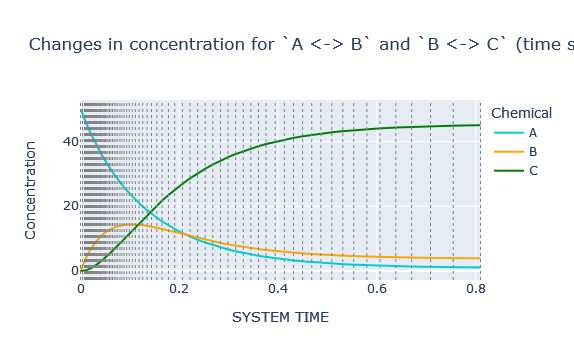

In [8]:
dynamics.plot_history(colors=['darkturquoise', 'orange', 'green'], show_intervals=True)

In [25]:
dynamics.is_in_equilibrium(tolerance=12)

0: A <-> B
Final concentrations: [A] = 1.096 ; [B] = 3.898
1. Ratio of reactant/product concentrations, adjusted for reaction orders: 3.55592
    Formula used:  [B] / [A]
2. Ratio of forward/reverse reaction rates: 4
Discrepancy between the two values: 11.1 %
Reaction IS in equilibrium (within 12% tolerance)

1: B <-> C
Final concentrations: [B] = 3.898 ; [C] = 45.01
1. Ratio of reactant/product concentrations, adjusted for reaction orders: 11.5475
    Formula used:  [C] / [B]
2. Ratio of forward/reverse reaction rates: 12
Discrepancy between the two values: 3.771 %
Reaction IS in equilibrium (within 12% tolerance)



True

# PART 2 - This is the starting point of fitting the data from part 1.  
### We're given the data of the time evolution of `A` and `C`, and we want to try to model the complex reaction `A <-> C`

Let's start by taking stock of the actual data (saved during the simulation of part 1):

In [10]:
# For this analysis, we're NOT given the intermediary B
df = dynamics.get_history(columns=["SYSTEM TIME", "A", "C", "caption"])
df

SYSTEM TIME          A          C             caption
0      0.000000  50.000000   0.000000   Initialized state
1      0.004000  48.400000   0.000000   1st reaction step
2      0.008000  46.864000   0.076800                    
3      0.010000  46.126413   0.150067                    
4      0.011000  45.764849   0.194599                    
..          ...        ...        ...                 ...
81     0.638365   1.497612  44.279102                    
82     0.670313   1.384698  44.483579                    
83     0.708651   1.276811  44.678990                    
84     0.754656   1.179000  44.856174                    
85     0.809862   1.096061  45.006431  last reaction step

[86 rows x 4 columns]

## Column B is NOT given to us.  For example, `B` might be an intermediary we can't measure.  
#### Only [A] and [C] are given to us, on some variably-spaced time grid

#### Let's extract some columns, as Numpy arrays:

In [11]:
t_arr = df["SYSTEM TIME"].to_numpy()   # The independent variable : Time

In [12]:
A_conc = df["A"].to_numpy()

In [13]:
C_conc = df["C"].to_numpy()

#### If the composite reaction `A <-> C` could be modeled as an elementary reaction, we'd expect the rate of change of [C] to be proportional to [A]  
Let's see what happens if we try to do such a linear fit!

Total REACTANT + PRODUCT has a median of 41.62, 
    with standard deviation 3.725 (ideally should be zero)
The sum of the time derivatives of reactant and product 
    has a median of -40.51 (ideally should be zero)
Least square fit: Y = 63.02 + 1.008 X
    where X is the array [A] and Y is the time gradient of C

-> ESTIMATED RATE CONSTANTS: kF = 2.522 , kR = -1.514


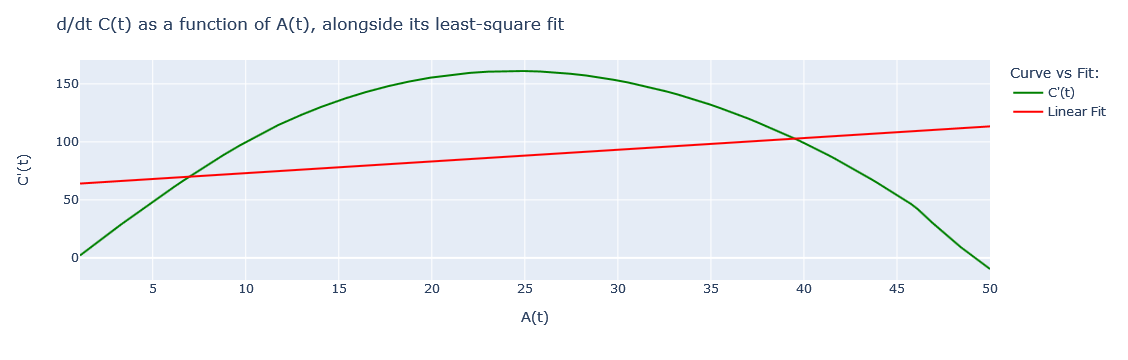

In [14]:
dynamics.estimate_rate_constants_simple(t=t_arr, A_conc=A_conc, B_conc=C_conc, reactant_name="A", product_name="C")

### The least-square fit is awful : the complex reaction `A <-> C` doesn't seem to be amenable to being modeled as a simple reaction with some suitable rate constants
Probably not too surprising given our "secret" knowledge from Part 1 that the complex reaction originates from 2 elementary reactions where the intermediate product builds up at one point

### A glance at the above diagram reveals much-better linear fits, if split into 2 portions, one where A(t) ranges from 0 to about 24, and one from about 24 to 50   
Indeed, revisiting the early portion of the time plot from Part 1, one can see an inflection in the [C] green curve roughly around time t=0.1, which is when [A] is around 24 (blue).  That's shortly after the peak of the mystery intermediate B (orange).    

We'll pick time **t=0.1** as the divider between the 2 domains of the `A <-> C` time evolution that we want to model. 

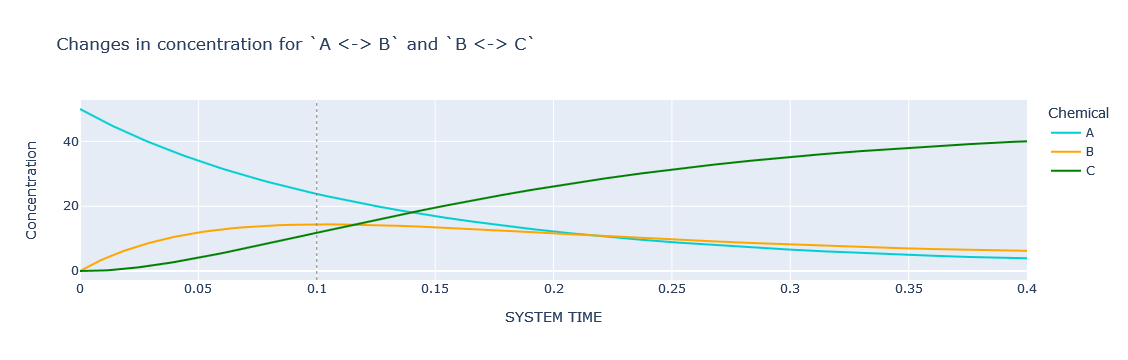

In [15]:
dynamics.plot_history(colors=['darkturquoise', 'orange', 'green'], xrange=[0, 0.4], 
                      vertical_lines=[0.1])

#### Let's locate where the t = 0.1 point occurs in the data

In [16]:
dynamics.get_history(t=0.1)

search_value  SYSTEM TIME          A          B         C caption
47           0.1     0.098644  24.020441  14.383519  11.59604

### Let's split the `A_conc` and `C_conc` arrays we extracted earlier (with the entire time evolution of, respectively, [A] and [C]) into two parts:  
1) points numbered 0 thru 47   
2) points 48 - end

In [17]:
A_conc_early = A_conc[:48]
A_conc_early

array([50.        , 48.4       , 46.864     , 46.1264128 , 45.76484854,
       45.40681085, 45.05225696, 44.70114469, 44.35343246, 44.00907929,
       43.66804478, 43.33028909, 42.99577298, 42.66445773, 42.33630518,
       42.0112777 , 41.68933821, 41.37045012, 41.0545774 , 40.74168448,
       40.36974668, 40.00199955, 39.6383842 , 39.27884274, 38.8522133 ,
       38.43128765, 38.01597063, 37.52420869, 37.04025733, 36.56396179,
       36.09517097, 35.54145062, 34.99811725, 34.46492785, 33.83698995,
       33.2229888 , 32.62253891, 31.91781348, 31.23154675, 30.56313706,
       29.78178056, 29.02450702, 28.29039508, 27.43620083, 26.61288888,
       25.81907912, 24.90034509, 24.02044078])

In [18]:
A_conc_late = A_conc[48:]
A_conc_late

array([23.0087328 , 22.04732192, 20.95032368, 19.91729654, 18.74901409,
       17.66042497, 16.44195241, 15.32047581, 14.08019853, 12.95495829,
       11.72795618, 10.63352278,  9.65555453,  8.78031868,  7.99601836,
        7.29245209,  6.66074533,  6.09313687,  5.5828077 ,  5.12374233,
        4.71061569,  4.33869982,  3.93680355,  3.5827847 ,  3.27084615,
        2.99592113,  2.75357274,  2.5399097 ,  2.31383613,  2.11982431,
        1.9533093 ,  1.78179739,  1.63943071,  1.49761239,  1.38469771,
        1.2768105 ,  1.17899973,  1.09606101])

In [19]:
len(A_conc_early) + len(A_conc_late) - len(A_conc)    # Double-check we got all points

0

In [20]:
# Same for [C] and for t_arr
C_conc_early = C_conc[:48]
C_conc_late = C_conc[48:]

t_arr_early = t_arr[:48]
t_arr_late = t_arr[48:]

### I. Let's start with the EARLY region, when t < 0.1

Total REACTANT + PRODUCT has a median of 40.88, 
    with standard deviation 3.719 (ideally should be zero)
The sum of the time derivatives of reactant and product 
    has a median of -190.1 (ideally should be zero)
Least square fit: Y = 339.8 + -6.239 X
    where X is the array [A] and Y is the time gradient of C

-> ESTIMATED RATE CONSTANTS: kF = 2.073 , kR = -8.312


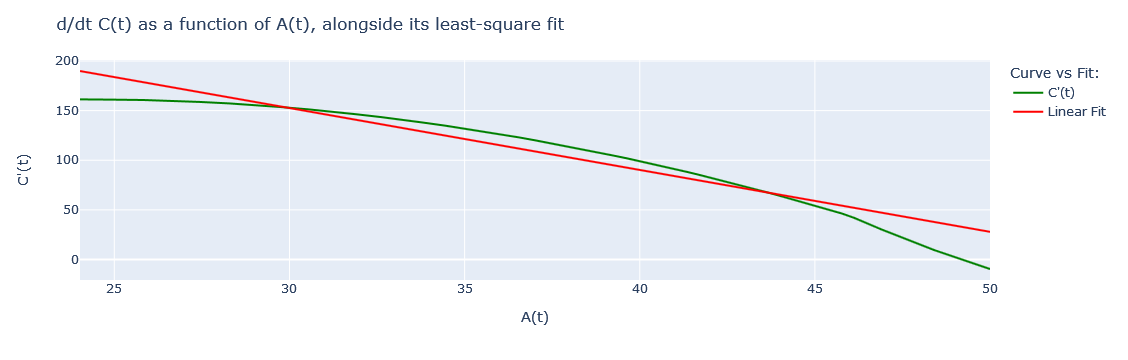

In [21]:
dynamics.estimate_rate_constants_simple(t=t_arr_early, A_conc=A_conc_early, B_conc=C_conc_early,
                                        reactant_name="A", product_name="C")

Trying to fit an elementary reaction to that region leads to a **negative** reverse rate constant!  
It's no surprise that an elementary reaction is a good fit, if one observes what happens to the time evolution of the concentrations.  Repeating the earlier plot, but only showing `A` and `C` (i.e. hiding the intermediary `B`):

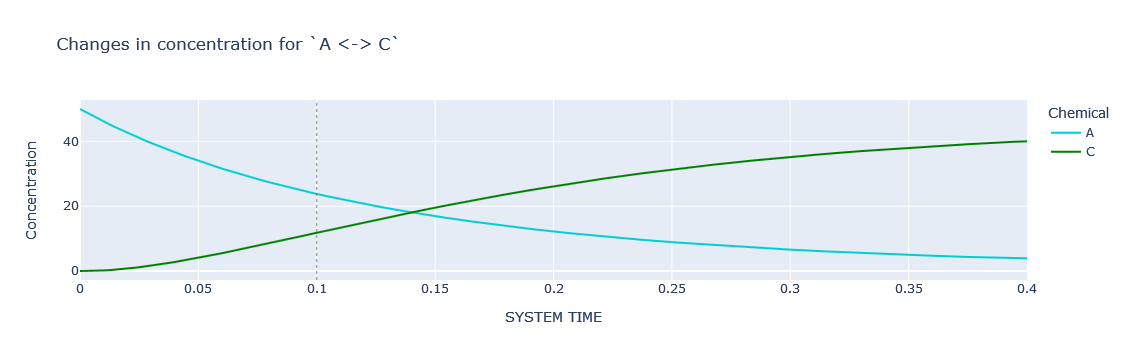

In [22]:
dynamics.plot_history(colors=['darkturquoise', 'green'], xrange=[0, 0.4], vertical_lines=[0.1], 
                     chemicals=['A', 'C'], title="Changes in concentration for `A <-> C`")

In the zone to the left of the vertical dashed line:  
when the reactant `A` is plentiful, the rate of change (gradient) of the product `C` is low - and vice versa.  
Does that look like an elementary reaction in its kinetics?  Nope!

### II. And now let's consider the LATE region, when t > 0.1

Total REACTANT + PRODUCT has a median of 42.74, 
    with standard deviation 3.695 (ideally should be zero)
The sum of the time derivatives of reactant and product 
    has a median of 16.91 (ideally should be zero)
Least square fit: Y = 4.132 + 7.995 X
    where X is the array [A] and Y is the time gradient of C

-> ESTIMATED RATE CONSTANTS: kF = 8.091 , kR = -0.09668


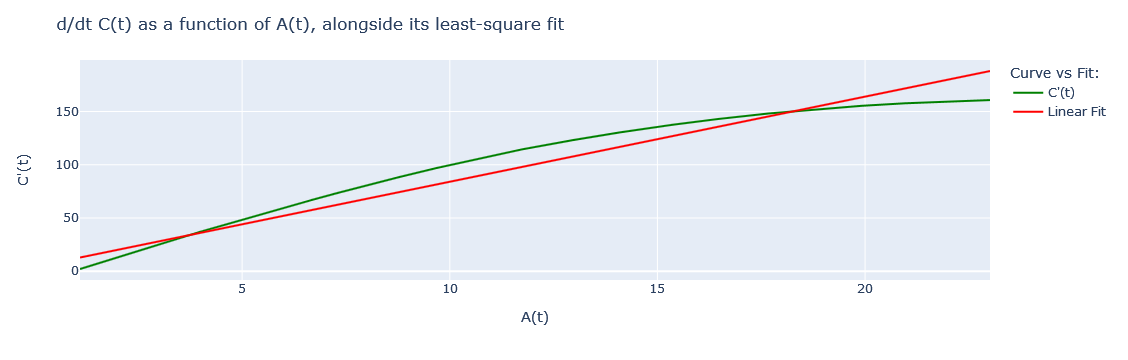

In [23]:
dynamics.estimate_rate_constants_simple(t=t_arr_late, A_conc=A_conc_late, B_conc=C_conc_late,
                                        reactant_name="A", product_name="C")

This time we have an adequate linear fit AND meaningful rate constants : kF of about 8 and kR of about 0.  Do those numbers sound familiar?  A definite resemblance to the kF=8, kR=2 of the SLOWER elementary reaction `A <-> B`!  

#### The slower `A <-> B` reaction dominates the kinetics, from about t=0.1 on  

Let's see the graph again:

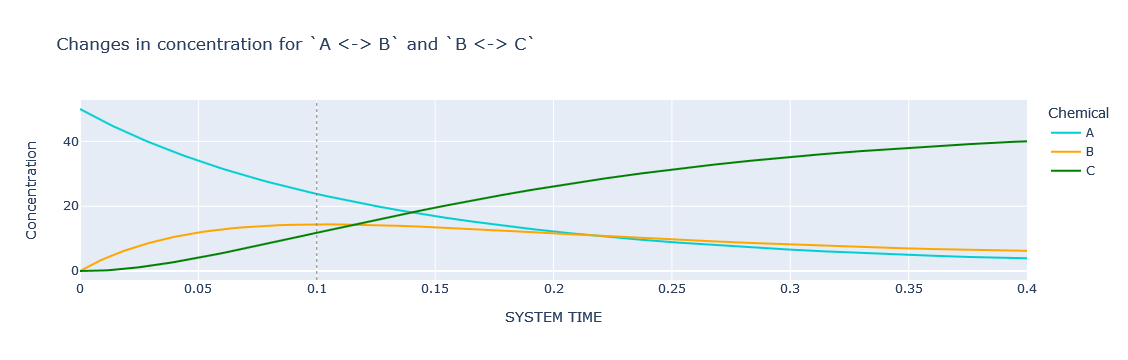

In [24]:
dynamics.plot_history(colors=['darkturquoise', 'orange', 'green'], xrange=[0, 0.4], 
                      vertical_lines=[0.1])

A possible conclusion to draw is that, in this case, the earlier part of the complex (compound) reaction `A <-> C` cannot be modeled by an elementary reaction, while the later part can indeed be modeled by a 1st order elementary reaction, with kinetics similar to the slower `A <-> B` reaction

**The intuition:** imagine `A <-> B <-> C` as a supply line.  
`A <-> B` is slow, but the moment something arrives in B, it's very quickly moved to C.  
The slow link (`A <-> B`) largely determines the kinetics of the supply line.

### While it's a well-known Chemistry notion that the slower reaction is the rate-determining step in a chain, we saw in this experiment  that **the complex reaction could be roughly modeled with the rate constants of the slower reaction ONLY AFTER SOME TIME**.  

If we were interested in early transients (for example, if diffusion quickly intervened), we couldn't use that model.

#### Is that surprising?  At early times, compare the inflection of the final product, C, of the composite reaction vs. the inflection of the product of a simple reaction (such as B in experiment `react1`, both appearing in green.)

#### In the continuation experiment, `cascade_2_b`, we explore the scenario where the 2 elementary reactions are much more different from each other